<a href="https://colab.research.google.com/github/ilyasIA25/ilyasIA25/blob/main/PCA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [201]:
# @title
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

DATA_PATH = Path("/content/Recap_donnee.xlsx")
META_PATH = Path("/content/meta_donnees.xlsx")

df_raw  = pd.read_excel(DATA_PATH, header=None)
df_meta = pd.read_excel(META_PATH)

df_meta.columns = [str(c).strip() for c in df_meta.columns]
df_meta["sample_id"] = df_meta["sample_id"].astype(str).str.strip().str.upper()

In [202]:
# @title
row_sample = df_raw.iloc[1]   # ids échantillons
row_kind   = df_raw.iloc[2]   # "Val" / "Std dev"

df_vars = df_raw.iloc[3:, [0]].copy()
df_vars.columns = ["variable"]
df_vars["variable"] = df_vars["variable"].astype(str).str.strip()

records = []
ncols = df_raw.shape[1]

for c in range(1, ncols):
    kind = row_kind.iloc[c]
    samp = row_sample.iloc[c]

    if not (isinstance(kind, str) and kind.strip().lower().startswith("val")):
        continue
    if pd.isna(samp):
        continue

    if isinstance(samp, (int, float, np.integer, np.floating)):
        sample_id = f"ECH{int(samp)}"
    else:
        s = str(samp).strip().upper()
        if s.startswith("ECH"):
            sample_id = s
        else:
            continue

    col_vals = df_raw.iloc[3:, c].reset_index(drop=True)
    for v, val in zip(df_vars["variable"].values, col_vals.values):
        if pd.isna(val):
            continue
        records.append({"sample_id": sample_id, "variable": v, "value": float(val)})

df_long = pd.DataFrame(records)
df_long["sample_id"] = df_long["sample_id"].astype(str).str.strip().str.upper()
display(df_long.head(10))

,sample_id,variable,value
0,ECH1,e coating,22.00
1,ECH1,Ra,183.90
2,ECH1,E*,3871.60
3,ECH1,HIT,100.90
4,ECH1,CIT,24.10
5,ECH1,Welast,13.10
6,ECH1,Wplast,66.90
7,ECH1,E' à 20°C,2456.60
8,ECH1,Tg-E',33.20
9,ECH1,Max tan δ,0.88


In [203]:
# @title
df_vals = (
    df_long.pivot_table(index="sample_id", columns="variable", values="value", aggfunc="mean")
    .reset_index()
)

def pick_col(df, keywords):
    low = {c.lower(): c for c in df.columns}
    for kw in keywords:
        for cl, orig in low.items():
            if kw in cl:
                return orig
    return None

# récup colonnes (adaptatif)
col_E      = "E" if "E" in df_vals.columns else pick_col(df_vals, [" e "])
col_Estar  = pick_col(df_vals, ["e*", "e_star", "e star", "e′", "e'"])
col_Tg     = pick_col(df_vals, ["tg"])
col_tanmax = pick_col(df_vals, ["max tan", "tan δ", "tanδ", "tand", "tandmax"])
col_FWHM   = pick_col(df_vals, ["fwhm"])
col_HIT    = pick_col(df_vals, ["hit"])

rename_map = {}
if col_E      is not None: rename_map[col_E] = "E"
if col_Estar  is not None: rename_map[col_Estar] = "E_star"
if col_Tg     is not None: rename_map[col_Tg] = "Tg"
if col_tanmax is not None: rename_map[col_tanmax] = "tanDmax"
if col_FWHM   is not None: rename_map[col_FWHM] = "FWHM"
if col_HIT    is not None: rename_map[col_HIT] = "HIT"

df_vals = df_vals.rename(columns=rename_map)

# merge meta (on garde tous les échantillons qui ont au moins une valeur)
df_full = df_vals.merge(df_meta, on="sample_id", how="left")
df_full = df_full.sort_values("sample_id").reset_index(drop=True)

display(df_full.head(12))
print("Colonnes disponibles:", [c for c in ["E","E_star","Tg","tanDmax","FWHM","HIT"] if c in df_full.columns])

,sample_id,CIT,E,E' à 20°C,E_star,FWHM,Fdelam,HIT,tanDmax,Ra,...,wax,primer_type,hardness_mpa,hardness_std_mpa,reduced_modulus_mpa,modulus_std_mpa,creep_pct,elastic_work_pj,plastic_work_pj,plastic_ratio
0,ECH1,24.10,1265.6,2456.6,3871.6,19.1,NaN,100.9,0.88,183.9,...,NaN,PE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ECH10,77.90,40.7,255.8,333.4,21.2,NaN,3.7,1.30,199.9,...,sans,PE,25.026,3.049,2727.664,95.918,80.593,8.736,187.537,0.955491
2,ECH11,80.60,647.8,1606.6,2727.7,20.0,2.48,25.1,2.16,161.2,...,avec,PU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ECH12,60.20,558.6,1374.3,2922.5,16.3,NaN,39.5,2.29,206.6,...,sans,PE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ECH13,77.10,266.6,291.4,141.4,23.0,1.82,2.2,1.40,217.6,...,avec,PU,21.821,1.823,2596.860,94.316,84.509,9.356,222.545,0.959655
5,ECH14,84.50,778.5,2143.7,2596.9,20.0,2.65,21.8,2.20,114.8,...,avec,PU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,ECH15,70.40,592.8,1483.4,3068.4,12.8,2.65,31.6,2.30,178.6,...,sans,PU,2.419,0.143,204.250,11.798,80.995,41.266,698.273,0.944200
7,ECH16,80.99,40.7,255.8,204.3,21.2,2.05,2.4,1.30,161.7,...,sans,PU,30.619,4.219,2685.048,103.563,72.155,10.822,179.582,0.943163
8,ECH17,72.20,647.8,1606.6,2685.1,20.0,2.72,30.6,2.16,126.6,...,sans,PU,26.967,1.700,2530.812,58.563,77.126,10.787,194.384,0.947424
9,ECH18,77.10,558.6,1374.3,2530.8,16.3,2.97,26.9,2.29,146.6,...,sans,PU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Colonnes disponibles: ['E', 'E_star', 'Tg', 'tanDmax', 'FWHM', 'HIT']


In [204]:
# @title
base_features = [c for c in ["E","E_star","Tg","tanDmax","FWHM","HIT"] if c in df_full.columns]

# on teste : garder tout, ou enlever 1 variable -> choisir le meilleur total PC1+PC2
def pca_score(df, feats):
    d = df.dropna(subset=feats)
    if len(d) < 3:
        return None, None, None
    X = d[feats].values
    Xz = StandardScaler().fit_transform(X)
    p = PCA(n_components=2).fit(Xz)
    total = float(p.explained_variance_ratio_.sum())
    return total, p, d

candidates = []
# option 1 : aucun retrait
total, p, d = pca_score(df_full, base_features)
if total is not None:
    candidates.append((total, base_features, p, d))

# option 2 : retirer 1 variable (si >= 4 variables restantes)
if len(base_features) >= 5:
    for drop in base_features:
        feats = [f for f in base_features if f != drop]
        total, p, d = pca_score(df_full, feats)
        if total is not None:
            candidates.append((total, feats, p, d))

# meilleur choix
candidates.sort(key=lambda x: x[0], reverse=True)
best_total, FEATURES, pca, df_pca_ready = candidates[0]

print("Features retenues:", FEATURES)
print(f"Variance expliquée PC1+PC2 = {best_total*100:.1f}%")
print(f"Nb échantillons PCA = {len(df_pca_ready)}")

# projection
X = df_pca_ready[FEATURES].values
Xz = StandardScaler().fit_transform(X)
Z = pca.transform(Xz)

df_scores = df_pca_ready[["sample_id"]].copy()
for col in ["process", "paint_color", "primer_type"]:
    if col in df_pca_ready.columns:
        df_scores[col] = df_pca_ready[col]
df_scores["PC1"] = Z[:,0]
df_scores["PC2"] = Z[:,1]

expl = pca.explained_variance_ratio_ * 100
print(f"PC1={expl[0]:.1f}% | PC2={expl[1]:.1f}% | Total={expl.sum():.1f}%")
display(df_scores.head(10))

Features retenues: ['E', 'E_star', 'Tg', 'tanDmax', 'HIT']
Variance expliquée PC1+PC2 = 96.8%
Nb échantillons PCA = 18
PC1=72.4% | PC2=24.4% | Total=96.8%


,sample_id,process,paint_color,primer_type,PC1,PC2
0,ECH1,EB,blanc,PE,3.405550,-0.672902
1,ECH10,SB,gris,PE,-2.847039,-1.218762
2,ECH11,SB,blanc,PU,-0.205683,1.122194
3,ECH12,SB,clear,PE,-0.165196,1.309947
4,ECH13,SB,gris,PU,-2.692460,-1.118539
5,ECH14,SB,clear,PU,-0.164309,1.157719
6,ECH15,SB,blanc,PU,-0.262401,1.433691
7,ECH16,SB,gris,PU,-2.915503,-1.267445
8,ECH17,SB,clear,PU,-0.136107,1.072279
9,ECH18,SB,clear,PU,-0.507476,1.211656


In [205]:
# @title
loadings = pca.components_.T  # (n_features, 2)

df_pca_recap = pd.DataFrame({
    "feature": FEATURES,
    "loading_PC1": loadings[:,0],
    "loading_PC2": loadings[:,1],
})

# contributions (au sens "importance" ~ loading^2) normalisées par axe
df_pca_recap["contrib_PC1_%"] = 100 * (df_pca_recap["loading_PC1"]**2) / (df_pca_recap["loading_PC1"]**2).sum()
df_pca_recap["contrib_PC2_%"] = 100 * (df_pca_recap["loading_PC2"]**2) / (df_pca_recap["loading_PC2"]**2).sum()

df_var = pd.DataFrame({
    "PC": ["PC1", "PC2"],
    "explained_variance_%": expl
})

display(df_var)
display(df_pca_recap.sort_values("contrib_PC1_%", ascending=False))

,PC,explained_variance_%
0,PC1,72.398604
1,PC2,24.427947


,feature,loading_PC1,loading_PC2,contrib_PC1_%,contrib_PC2_%
0,E,0.515782,0.037935,26.603136,0.143904
2,Tg,0.513018,0.025547,26.318730,0.065267
4,HIT,0.505157,-0.185532,25.518335,3.442210
1,E_star,0.428125,0.497777,18.329089,24.778177
3,tanDmax,-0.179742,0.845993,3.230710,71.570442


In [206]:
# @title
import plotly.graph_objects as go
import numpy as np

# --- 1. Nettoyage des données pour éviter l'erreur sorted() ---
# On convertit en string et on gère les valeurs manquantes pour le tri
process_list = sorted([str(x) for x in df_scores["process"].unique() if x is not None])
color_list = sorted([str(x) for x in df_scores["paint_color"].unique() if x is not None])

# --- 2. Paramètres d'échelle ---
loadings = pca.components_.T
scale = 0.5 * max(df_scores["PC1"].abs().max(), df_scores["PC2"].abs().max())

# --- 3. Création de la figure ---
fig = go.Figure()

# --- 4. Tracé des points ---
symbols = {"EB": "square", "SB": "circle"}
colors = {"gris": "#4a4a4a", "blanc": "#ffffff", "clear": "#E1F5FE"}

for proc in process_list:
    for color in color_list:
        mask = (df_scores["process"].astype(str) == proc) & (df_scores["paint_color"].astype(str) == color)
        if not mask.any(): continue

        sub_df = df_scores[mask]

        fig.add_trace(go.Scatter(
            x=sub_df["PC1"], y=sub_df["PC2"],
            mode='markers',
            marker=dict(
                size=11,
                symbol=symbols.get(proc, "circle"),
                color=colors.get(color, "#bbbbbb"),
                line=dict(width=1, color='black')
            ),
            name=f"{proc} - {color}",
            text=sub_df["sample_id"],
            hovertemplate="<b>ID: %{text}</b><br>PC1: %{x:.2f}<br>PC2: %{y:.2f}<extra></extra>"
        ))

# --- 5. Flèches des variables (Loadings) partant de l'origine (0,0) ---
pretty = {"E": "E", "E_star": "E*", "Tg": "Tg", "tanDmax": "max[tan(δ)]", "FWHM": "FWHM", "HIT": "HIT"}

for i, f in enumerate(FEATURES):
    vx, vy = loadings[i, 0] * scale, loadings[i, 1] * scale

    # Flèche avec pointe
    fig.add_annotation(
        x=vx, y=vy, ax=0, ay=0,
        xref="x", yref="y", axref="x", ayref="y",
        showarrow=True, arrowhead=3, arrowsize=1.2, arrowwidth=2,
        arrowcolor="rgba(180, 0, 0, 0.8)"
    )

    # Décalage E / Tg
    norm = np.hypot(vx, vy) + 1e-9
    px, py = -vy/norm, vx/norm
    offset = 0.22

    if f == "E":
        tx, ty = vx + px * offset, vy + py * offset
    elif f in ["Tg", "Tg "]:
        tx, ty = vx - px * offset, vy - py * offset
    else:
        tx, ty = vx * 1.15, vy * 1.15

    fig.add_annotation(
        x=tx, y=ty, text=f"<b>{pretty.get(f, f)}</b>",
        showarrow=False, font=dict(size=12, color="black"),
        bgcolor="rgba(255, 255, 255, 0.8)"
    )

# --- 6. Mise en forme finale (Titre centré, Légende interne) ---
fig.update_layout(
    title={
        'text': "<b>ANALYSE EN COMPOSANTES PRINCIPALES : MÉCANISMES DE RÉTICULATION</b>",
        'y': 0.96, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'
    },
    xaxis_title=f"<b>PC1 ({pca.explained_variance_ratio_[0]*100:.1f} %)</b>",
    yaxis_title=f"<b>PC2 ({pca.explained_variance_ratio_[1]*100:.1f} %)</b>",
    template="plotly_white",
    width=900, height=800,
    yaxis=dict(scaleanchor="x", scaleratio=1, zeroline=True, zerolinewidth=1.5, zerolinecolor='black'),
    xaxis=dict(zeroline=True, zerolinewidth=1.5, zerolinecolor='black'),
    legend=dict(
        title_text="<b>Échantillons</b>",
        yanchor="top", y=0.98, xanchor="left", x=0.02,
        bgcolor="rgba(255, 255, 255, 0.7)", bordercolor="Black", borderwidth=1
    )
)

fig.show()


In [207]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr


In [208]:
# @title
df_ET = df_full[['sample_id', 'E', 'Tg']].dropna().reset_index(drop=True)

print("Nombre d'échantillons utilisés :", len(df_ET))
display(df_ET)

Nombre d'échantillons utilisés : 18


,sample_id,E,Tg
0,ECH1,1265.6,33.2
1,ECH10,40.7,9.9
2,ECH11,647.8,22.5
3,ECH12,558.6,21.2
4,ECH13,266.6,9.1
5,ECH14,778.5,21.9
6,ECH15,592.8,20.0
7,ECH16,40.7,9.9
8,ECH17,647.8,22.5
9,ECH18,558.6,21.2


In [209]:
# @title
x = df_ET['Tg'].values
y = df_ET['E'].values

r_pearson, p_pearson = pearsonr(x, y)
r_spearman, p_spearman = spearmanr(x, y)

print(f"Pearson r(E, Tg) = {r_pearson:.3f}   p = {p_pearson:.2e}")
print(f"Spearman ρ(E, Tg) = {r_spearman:.3f}   p = {p_spearman:.2e}")

Pearson r(E, Tg) = 0.962   p = 2.08e-10
Spearman ρ(E, Tg) = 0.933   p = 1.59e-08


In [210]:
# @title
a, b = np.polyfit(x, y, 1)
r2 = r_pearson**2

print(f"E = {a:.2f} · Tg + {b:.1f}")
print(f"R² = {r2:.3f}")

E = 41.59 · Tg + -246.7
R² = 0.925


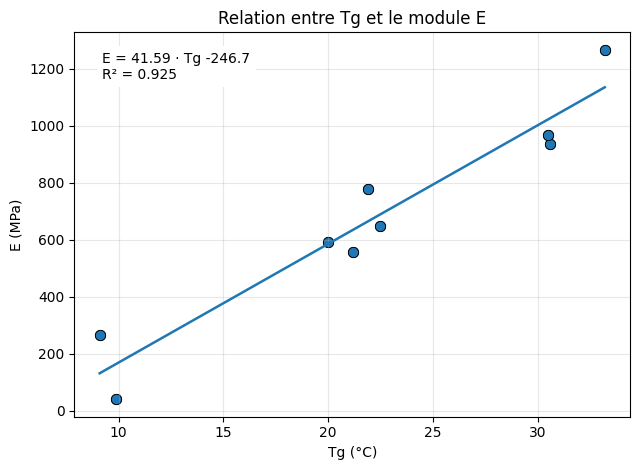

In [211]:
# @title
xx = np.linspace(x.min(), x.max(), 300)
yy = a * xx + b

fig, ax = plt.subplots(figsize=(6.5, 4.8))

ax.scatter(x, y, s=55, edgecolor='k', linewidth=0.6)
ax.plot(xx, yy, linewidth=1.8)

ax.set_xlabel("Tg (°C)")
ax.set_ylabel("E (MPa)")
ax.set_title("Relation entre Tg et le module E")

eq_text = f"E = {a:.2f} · Tg {b:.1f}\nR² = {r2:.3f}"
ax.text(
    0.05, 0.95, eq_text,
    transform=ax.transAxes,
    ha='left', va='top',
    bbox=dict(facecolor='white', edgecolor='none')
)

ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [212]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, spearmanr
from scipy.optimize import curve_fit

# On suppose que ton dataframe "large" existe déjà (celui qui contient toutes les valeurs),
# typiquement df_full (ou df_all / df_pca selon ton notebook).
# -> Remplace ICI si ton nom est différent.
DF = df_full

# Colonnes attendues (mêmes noms que dans ton notebook)
COL_ID = "sample_id"
COL_PROC = "process"         # EB / SB
COL_COLOR = "paint_color"    # clear / blanc / gris
COL_TG = "Tg"
COL_E = "E"
COL_TAND = "tanDmax"         # max[tan(delta)]

# Couleurs (comme tu voulais)
paint_palette = {
    "clear": "#1f77b4",   # bleu azur profond
    "blanc": "#e6e6e6",   # gris très clair
    "gris":  "#2b2b2b",   # gris foncé / quasi noir
}
edge_palette = {
    "clear": "#1f77b4",
    "blanc": "#000000",
    "gris":  "#2b2b2b",
}

marker_by_proc = {"EB": "s", "SB": "o"}   # carré / rond

def _as_std_proc(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().upper()
    if x in ["EB", "E-B", "E BEAM", "ELECTRON BEAM"]:
        return "EB"
    if x in ["SB", "S-B"]:
        return "SB"
    return x

DF = DF.copy()
DF[COL_PROC] = DF[COL_PROC].apply(_as_std_proc)
DF[COL_COLOR] = DF[COL_COLOR].astype("string").str.strip().str.lower()

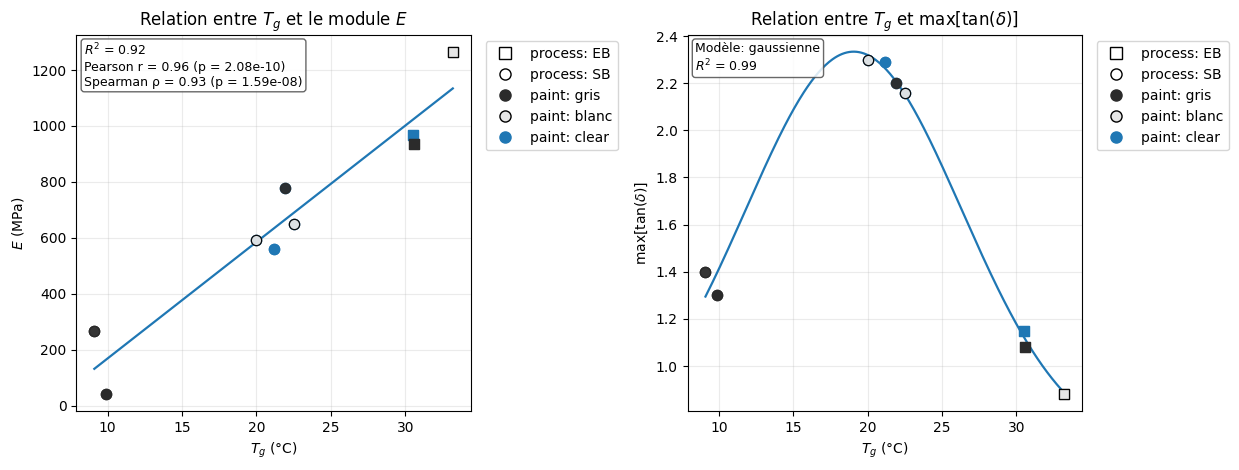

In [213]:
# @title
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def gaussian(x, a, mu, sigma, c):
    return a * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + c

def scatter_by_groups(ax, df, xcol, ycol, title):
    ax.set_title(title)
    ax.grid(alpha=0.25)

    for proc in ["EB", "SB"]:
        for col in ["clear", "blanc", "gris"]:
            sub = df[(df[COL_PROC] == proc) & (df[COL_COLOR] == col)]
            if len(sub) == 0:
                continue

            face = paint_palette.get(col, "#777777")
            edge = edge_palette.get(col, "#000000")
            marker = marker_by_proc.get(proc, "o")

            ax.scatter(
                sub[xcol], sub[ycol],
                s=55,
                marker=marker,
                facecolors=face,
                edgecolors=edge,
                linewidths=0.9,
                alpha=0.95,
                zorder=3
            )

def add_legend(ax):
    from matplotlib.lines import Line2D

    handles = []
    labels = []

    # Process
    handles += [
        Line2D([0],[0], marker="s", color="none", markerfacecolor="none", markeredgecolor="k", markersize=8, linewidth=0),
        Line2D([0],[0], marker="o", color="none", markerfacecolor="none", markeredgecolor="k", markersize=8, linewidth=0),
    ]
    labels += ["process: EB", "process: SB"]

    # Paint colors
    for col, name in [("gris","paint: gris"), ("blanc","paint: blanc"), ("clear","paint: clear")]:
        handles.append(
            Line2D([0],[0], marker="o", color="none",
                   markerfacecolor=paint_palette[col],
                   markeredgecolor=edge_palette[col],
                   markersize=8, linewidth=0)
        )
        labels.append(name)

    ax.legend(handles, labels, loc="upper left", bbox_to_anchor=(1.02, 1.0), frameon=True)

# -------------------------
# 1) Tg vs E (linéaire)
# -------------------------
df_TE = DF[[COL_ID, COL_PROC, COL_COLOR, COL_TG, COL_E]].dropna(subset=[COL_TG, COL_E]).copy()

x = df_TE[COL_TG].to_numpy().reshape(-1, 1)
y = df_TE[COL_E].to_numpy()

lin = LinearRegression().fit(x, y)
yhat = lin.predict(x)

r_p, p_p = pearsonr(df_TE[COL_TG], df_TE[COL_E])
r_s, p_s = spearmanr(df_TE[COL_TG], df_TE[COL_E])
R2 = r2_score(y, yhat)

xx = np.linspace(df_TE[COL_TG].min(), df_TE[COL_TG].max(), 200).reshape(-1, 1)
yy = lin.predict(xx)

# -------------------------
# 2) Tg vs tanDmax (non-linéaire)
#   - Fit gaussien (cloche) + poly2
# -------------------------
df_TD = DF[[COL_ID, COL_PROC, COL_COLOR, COL_TG, COL_TAND]].dropna(subset=[COL_TG, COL_TAND]).copy()

x2 = df_TD[COL_TG].to_numpy()
y2 = df_TD[COL_TAND].to_numpy()

# Poly2
coef2 = np.polyfit(x2, y2, 2)
poly2 = np.poly1d(coef2)
y2_poly = poly2(x2)
R2_poly = r2_score(y2, y2_poly)

# Gaussienne (initialisation robuste)
a0 = float(y2.max() - y2.min())
mu0 = float(x2.mean())
sigma0 = float(max(1.0, x2.std()))
c0 = float(y2.min())

R2_g = np.nan
popt = None
try:
    popt, _ = curve_fit(
        gaussian, x2, y2,
        p0=[a0, mu0, sigma0, c0],
        maxfev=10000
    )
    y2_g = gaussian(x2, *popt)
    R2_g = r2_score(y2, y2_g)
except Exception:
    popt = None

# Choix du modèle pour affichage
use_gauss = (popt is not None) and (R2_g >= R2_poly)

# -------------------------
# FIGURE
# -------------------------
fig, axes = plt.subplots(1, 2, figsize=(12.5, 4.8))

# Left: Tg vs E
ax = axes[0]
scatter_by_groups(ax, df_TE, COL_TG, COL_E, "Relation entre $T_g$ et le module $E$")
ax.plot(xx, yy, linewidth=1.6, zorder=2)
ax.set_xlabel("$T_g$ (°C)")
ax.set_ylabel("$E$ (MPa)")

txt = (
    f"$R^2$ = {R2:.2f}\n"
    f"Pearson r = {r_p:.2f} (p = {p_p:.2e})\n"
    f"Spearman ρ = {r_s:.2f} (p = {p_s:.2e})"
)
ax.text(0.02, 0.98, txt, transform=ax.transAxes, va="top", ha="left",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.3", alpha=0.85), fontsize=9)

add_legend(ax)

# Right: Tg vs tanDmax
ax2p = axes[1]
scatter_by_groups(ax2p, df_TD, COL_TG, COL_TAND, r"Relation entre $T_g$ et $\max[\tan(\delta)]$")
ax2p.set_xlabel("$T_g$ (°C)")
ax2p.set_ylabel(r"$\max[\tan(\delta)]$")

xxx = np.linspace(df_TD[COL_TG].min(), df_TD[COL_TG].max(), 300)

if use_gauss:
    ax2p.plot(xxx, gaussian(xxx, *popt), linewidth=1.6, zorder=2)
    ax2p.text(0.02, 0.98, f"Modèle: gaussienne\n$R^2$ = {R2_g:.2f}",
              transform=ax2p.transAxes, va="top", ha="left",
              bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.3", alpha=0.85), fontsize=9)
else:
    ax2p.plot(xxx, poly2(xxx), linewidth=1.6, zorder=2)
    ax2p.text(0.02, 0.98, f"Modèle: polynôme degré 2\n$R^2$ = {R2_poly:.2f}",
              transform=ax2p.transAxes, va="top", ha="left",
              bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="0.3", alpha=0.85), fontsize=9)

add_legend(ax2p)

plt.tight_layout()
plt.show()

In [214]:
# @title
import pandas as pd
import numpy as np

# Liste des grandeurs à inclure dans la PCA
features_pca = [
    "Tg",
    "tanDmax", # Corrected from 'max_tan_delta'
    "FWHM",
    "E_star",
    "E",
    # "sigma_y", # Removed as not found in df_full
    # "epsilon_r", # Removed as not found in df_full
    "HIT",
    "CIT",
    "Welast",
    "Wplast"
]

# Sous-dataframe PCA (using df_full instead of df)
df_pca = df_full[features_pca].copy()

# On garde uniquement les échantillons exploitables
df_pca = df_pca.dropna()

print(f"Nombre d'échantillons utilisés : {df_pca.shape[0]}")
display(df_pca.head())

Nombre d'échantillons utilisés : 18


,Tg,tanDmax,FWHM,E_star,E,HIT,CIT,Welast,Wplast
0,33.2,0.88,19.1,3871.6,1265.6,100.9,24.1,13.1,66.9
1,9.9,1.30,21.2,333.4,40.7,3.7,77.9,31.6,553.6
2,22.5,2.16,20.0,2727.7,647.8,25.1,80.6,8.7,187.5
3,21.2,2.29,16.3,2922.5,558.6,39.5,60.2,11.4,147.7
4,9.1,1.40,23.0,141.4,266.6,2.2,77.1,58.8,729.1


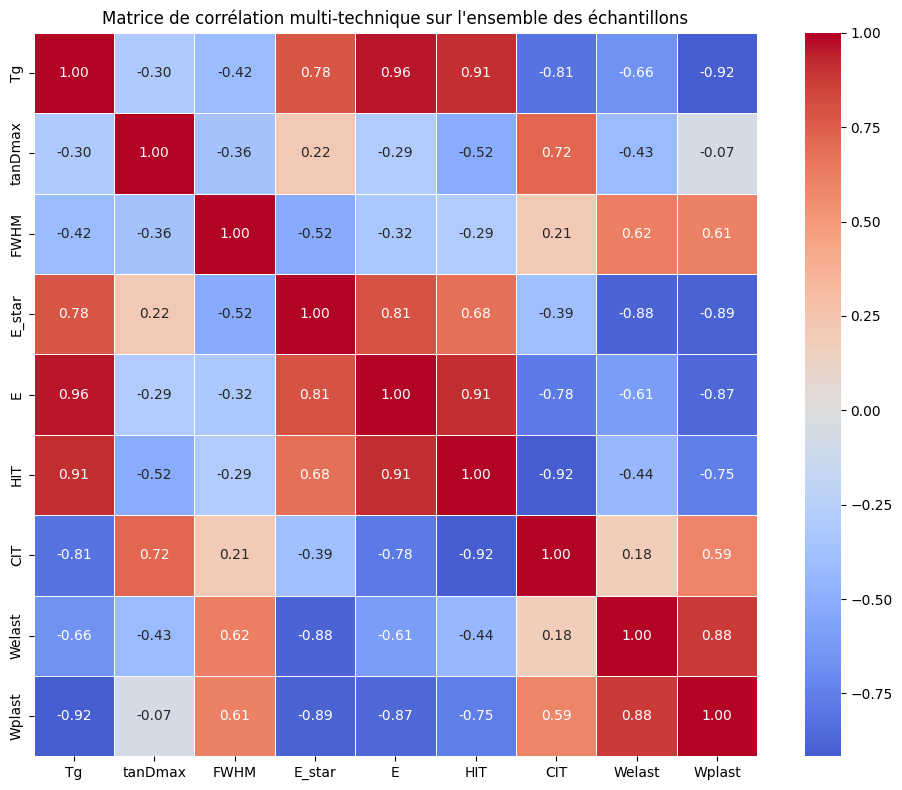

In [215]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns

corr = df_pca.corr(method="pearson")

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5
)

plt.title("Matrice de corrélation multi-technique sur l'ensemble des échantillons")
plt.tight_layout()
plt.show()

In [216]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

variables = [
    "Tg",
    "tanDmax",
    "FWHM",
    "E_star",
    "E",
    "HIT",
    "CIT",
    "Welast",
    "Wplast"
]

def plot_corr_matrix(df_sub, title):
    corr = df_sub[variables].corr(method="pearson")

    plt.figure(figsize=(7, 6))
    sns.heatmap(
        corr,
        vmin=-1,
        vmax=1,
        center=0,
        cmap="coolwarm",
        annot=True,
        fmt=".2f",
        square=True,
        cbar_kws={"label": "Coefficient de corrélation"}
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return corr

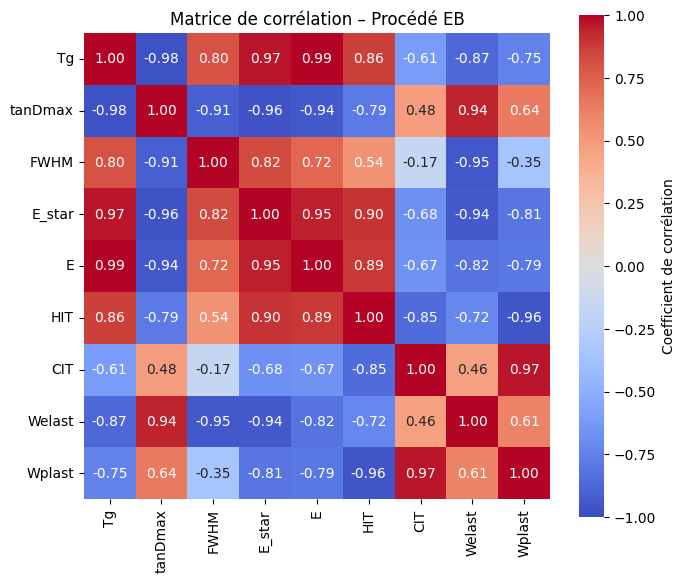

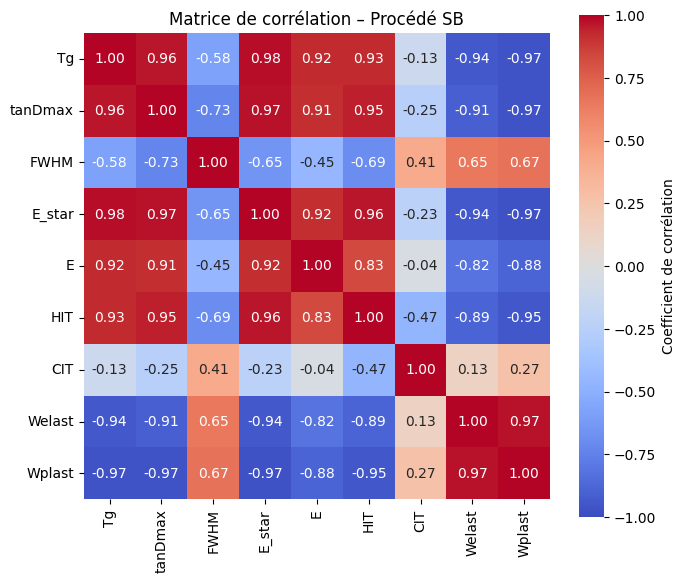

In [217]:
# @title
corr_EB = plot_corr_matrix(
    df_full[df_full["process"] == "EB"],
    "Matrice de corrélation – Procédé EB"
)

corr_SB = plot_corr_matrix(
    df_full[df_full["process"] == "SB"],
    "Matrice de corrélation – Procédé SB"
)

In [218]:

# @title
key_pairs = [
    ("Tg", "E"),
    ("Tg", "HIT"),
    ("Tg", "E_star"),
    ("Tg", "tanDmax"),
    ("tanDmax", "CIT"),
    ("tanDmax", "FWHM"),
    ("Wplast", "Tg"),
    ("Wplast", "E")
]

def extract_key_corr(df_sub, label):
    rows = []
    corr = df_sub[variables].corr()

    for a, b in key_pairs:
        rows.append({
            "group": label,
            "var_1": a,
            "var_2": b,
            "corr": corr.loc[a, b]
        })

    return pd.DataFrame(rows)

summary = pd.concat([
    extract_key_corr(df_full, "global"),
    extract_key_corr(df_full[df_full["process"] == "EB"], "EB"),
    extract_key_corr(df_full[df_full["process"] == "SB"], "SB"),
    extract_key_corr(df_full[df_full["paint_color"] == "gris"], "gris"),
    extract_key_corr(df_full[df_full["paint_color"] == "blanc"], "blanc"),
    extract_key_corr(df_full[df_full["paint_color"] == "clear"], "clear"),
])

display(summary)

,group,var_1,var_2,corr
0,global,Tg,E,0.961664
1,global,Tg,HIT,0.911281
2,global,Tg,E_star,0.781246
3,global,Tg,tanDmax,-0.296266
4,global,tanDmax,CIT,0.720439
5,global,tanDmax,FWHM,-0.364304
6,global,Wplast,Tg,-0.915303
7,global,Wplast,E,-0.866869
0,EB,Tg,E,0.992944
1,EB,Tg,HIT,0.863116


In [219]:
# @title
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

groups = {
    "global": df_full,
    "EB": df_full[df_full["process"] == "EB"],
    "SB": df_full[df_full["process"] == "SB"],
    "gris": df_full[df_full["paint_color"] == "gris"],
    "blanc": df_full[df_full["paint_color"] == "blanc"],
    "clear": df_full[df_full["paint_color"] == "clear"],
}

# Calcul des matrices de corrélation pour chaque groupe
corr_matrices = {}
for name, dfg in groups.items():
    if len(dfg) >= 4:
        corr_matrices[name] = dfg[variables].corr()

# Construction d'un tableau long : (var1, var2, groupe, corr)
records = []
for group, corr in corr_matrices.items():
    for i in corr.index:
        for j in corr.columns:
            if i != j:
                records.append({
                    "var_1": i,
                    "var_2": j,
                    "group": group,
                    "corr": corr.loc[i, j]
                })

df_corr_long = pd.DataFrame(records)

# Agrégation par paire de variables
summary = (
    df_corr_long
    .groupby(["var_1", "var_2"])
    .agg(
        mean_corr=("corr", "mean"),
        min_corr=("corr", "min"),
        max_corr=("corr", "max"),
        std_corr=("corr", "std"),
        n_groups=("corr", "count")
    )
    .reset_index()
)

# Critères de robustesse
ROBUST_MEAN = 0.85
ROBUST_SPREAD = 0.20
N_GROUPS_REQUIRED = len(corr_matrices)

robust_corr = summary[
    (summary["n_groups"] == N_GROUPS_REQUIRED) &
    (summary["mean_corr"].abs() >= ROBUST_MEAN) &
    ((summary["max_corr"] - summary["min_corr"]) <= ROBUST_SPREAD)
]

display(robust_corr.sort_values("mean_corr", ascending=False))

,var_1,var_2,mean_corr,min_corr,max_corr,std_corr,n_groups
12,E,Tg,0.959264,0.924898,0.992944,0.026715,6
41,Tg,E,0.959264,0.924898,0.992944,0.026715,6
44,Tg,HIT,0.922580,0.863116,0.988718,0.042555,6
36,HIT,Tg,0.922580,0.863116,0.988718,0.042555,6
21,E_star,Welast,-0.885346,-0.938410,-0.771399,0.061008,6
50,Welast,E_star,-0.885346,-0.938410,-0.771399,0.061008,6


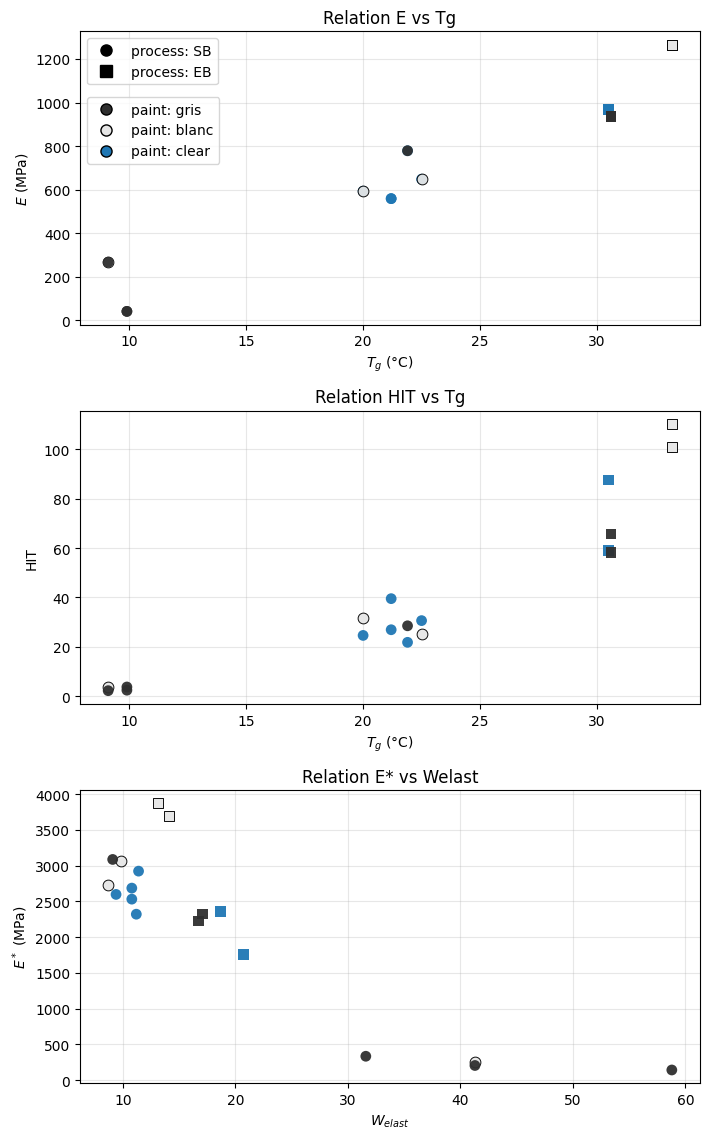

In [220]:
# @title
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

df = df_full.copy()

# Harmonisation légère (robuste si variations de casse/espaces)
df["process"] = df["process"].astype(str).str.strip().str.upper()
df["paint_color"] = df["paint_color"].astype(str).str.strip().str.lower()

# Palette pro (tu peux ajuster)
color_map = {
    "clear": "#1f77b4",   # bleu
    "blanc": "#e6e6e6",   # gris très clair
    "gris":  "#2f2f2f"    # gris foncé
}

marker_map = {
    "SB": "o",  # rond
    "EB": "s"   # carré
}

def scatter_by_process_and_color(ax, dsub, x, y):
    for proc, mk in marker_map.items():
        dp = dsub[dsub["process"] == proc]
        if dp.empty:
            continue
        for col, chex in color_map.items():
            dc = dp[dp["paint_color"] == col]
            if dc.empty:
                continue
            ax.scatter(
                dc[x], dc[y],
                s=60, marker=mk,
                c=chex,
                edgecolors="k" if col == "blanc" else "none",
                linewidths=0.7 if col == "blanc" else 0.0,
                alpha=0.95
            )

# --- Figure (3 graphes) ---
fig, axes = plt.subplots(3, 1, figsize=(7.2, 11.5), sharex=False)

pairs = [
    ("Tg", "E",      "Relation E vs Tg",        r"$T_g$ (°C)", r"$E$ (MPa)"),
    ("Tg", "HIT",    "Relation HIT vs Tg",      r"$T_g$ (°C)", r"HIT"),
    ("Welast", "E_star", "Relation E* vs Welast", r"$W_{elast}$", r"$E^*$ (MPa)")
]

for ax, (x, y, title, xl, yl) in zip(axes, pairs):
    dsub = df.dropna(subset=[x, y, "process", "paint_color"]).copy()
    scatter_by_process_and_color(ax, dsub, x, y)
    ax.set_title(title)
    ax.set_xlabel(xl)
    ax.set_ylabel(yl)
    ax.grid(alpha=0.3)
    ax.set_axisbelow(True)

# Légendes séparées : forme = process, couleur = paint_color
proc_handles = [
    Line2D([0], [0], marker=marker_map["SB"], color="k", linestyle="", markersize=8, label="process: SB"),
    Line2D([0], [0], marker=marker_map["EB"], color="k", linestyle="", markersize=8, label="process: EB"),
]
color_handles = [
    Line2D([0], [0], marker="o", color="none", markerfacecolor=color_map["gris"],  linestyle="", markersize=8, label="paint: gris"),
    Line2D([0], [0], marker="o", color="k",   markerfacecolor=color_map["blanc"], linestyle="", markersize=8, label="paint: blanc"),
    Line2D([0], [0], marker="o", color="none", markerfacecolor=color_map["clear"], linestyle="", markersize=8, label="paint: clear"),
]

axes[0].legend(handles=proc_handles, loc="upper left", frameon=True)
axes[0].add_artist(axes[0].legend(handles=proc_handles, loc="upper left", frameon=True))
axes[0].legend(handles=color_handles, loc="upper left", bbox_to_anchor=(0, 0.8), frameon=True)

plt.tight_layout()
plt.show()